In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy import stats


In [ ]:
# Project I
# Task I - Data Exploration and Pre-processing
# VoD - Pre-processing

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
target = "DispFrames"

# Main
for ds in dsList:
    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/X.csv", 
                       usecols = lambda column : column not in ["TimeStamp"])
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/Y.csv", 
                       usecols = [target])
    #print("yRaw:")
    #print(yRaw)    

    # Removing outliers
    z_scores = stats.zscore(yRaw)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    xRawLimited = xRaw[filtered_entries]
    #print("xRawLimited:")
    #print(xRawLimited)
    yRawLimited = yRaw[filtered_entries]
    #print("yRawLimited:")
    #print(yRawLimited)

    # Pre-Processing
    xRawNormL2 = preprocessing.normalize(xRawLimited, norm='l2')
    #print("xRawNormL2:")
    #print(xRawNormL2)

    xRawStandard = preprocessing.scale(xRawLimited)
    #print("xRawStandard:")
    #print(xRawStandard)

    xRawRestriction = preprocessing.MinMaxScaler().fit_transform(xRawLimited)
    #print("xRawRestriction:")
    #print(xRawRestriction)

    #Create dataframes and save files
    xLimited = pd.DataFrame(xRawLimited)
    #print("xLimited:")
    #print(xLimited)
    xLimited.to_csv(dir + ds + "/XLimited.csv")

    yLimited = pd.DataFrame(yRawLimited)
    #print("yLimited:")
    #print(yLimited)
    yLimited.to_csv(dir + ds + "/YLimited.csv")

    xNormL2 = pd.DataFrame(xRawNormL2)
    #print("xNormL2:")
    #print(xNormL2)
    xNormL2.to_csv(dir + ds + "/XNormL2.csv")

    xStandard = pd.DataFrame(xRawStandard)
    #print("xStandard:")
    #print(xStandard)
    xStandard.to_csv(dir + ds + "/XStandard.csv")

    xRestricted = pd.DataFrame(xRawRestriction)
    #print("xRestricted:")
    #print(xRestricted)
    xRestricted.to_csv(dir + ds + "/XRestricted.csv")


In [ ]:
# Project I
# Task I - Data Exploration and Pre-processing
# VoD - Feature Selection

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
target = "DispFrames"
k=16

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XRestricted.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    #Create a k-feature selector
    selector = SelectKBest(f_classif, k) 

    #Create a RandomForest Regressor 
    regr = RandomForestRegressor(max_depth=50, n_estimators=150, n_jobs=4, random_state=13)

    #Create (X,Y) train and test datasets
    xTrain, xTest, yTrain, yTest = train_test_split(xRaw, yRaw[target], test_size=0.3)

    #Do k-feature selection
    xTrainSelected = selector.fit_transform(xTrain, yTrain)
    xTestSelected = selector.transform(xTest)
    xRawSelected  = np.concatenate((xTrainSelected, xTestSelected))

    #Create Pandas Dataframe
    xSelected = pd.DataFrame(xRawSelected)
    #print(xSelected)

    #Save File
    xSelected.to_csv(dir + ds + "/XSelected.csv")

    #idxsSelected = selector.get_support(indices=True)
    #print(idxsSelected)


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD - Baseline Evaluation

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
#dsList = ["VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    results = pd.DataFrame(columns=['iteration', 'nmae'])
      
    for iter in range (1, iterations+1):
        print("Iteration: " + str(iter))

        # Create a RandomForest Regressor
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)

        # Create Training and Test Datasets
        xTrain, xTest, yTrain, yTest = train_test_split(xRaw, yRaw[target], test_size=0.3)

        # Build the Model
        regr.fit(xTrain, yTrain)

        # Do Predictions
        yPredicted = regr.predict(xTest)

        # Calculate NMAE
        nmae  = ((abs(yPredicted - yTest.values)).mean())/(yTest.values.mean())
        #print("NMAE: " + str(nmae))

        nr = results.append({'iteration': iter, 'nmae': nmae}, ignore_index=True)
        results = pd.concat([nr])

    results.to_csv(outdir + "p2t1-baseline-" + ds + ".csv")
    #print(results)


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD - Baseline Statistics

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t1-baseline-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['avg', 'stddev'])

    nr = graphResults.append({'avg': results['nmae'].mean(), 
                              'stddev': results['nmae'].std()}, ignore_index=True)
    graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv")


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD - Offline Small-Size

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))
      
        for iter in range (1, iterations+1):
            print("Iteration: " + str(iter))

            # Create a RandomForest Regressor
            regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)

            # Create Training and Test Datasets
            xTrain, xTest, yTrain, yTest = train_test_split(xRaw, yRaw[target], 
                                                            test_size=testSize, 
                                                            train_size=cacheSize)
            # Build the Model
            regr.fit(xTrain, yTrain)

            # Do Predictions
            yPredicted = regr.predict(xTest)

            # Calculate NMAE
            nmae  = (abs(yPredicted - yTest).mean())/yTest.mean()
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                ignore_index=True)
            results = pd.concat([nr])

    results.to_csv(outdir + "p2t1-offline-" + ds + ".csv")
    print(results)


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD - Statistics

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t1-offline-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t1-offline-stats-" + ds + ".csv")


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD - Figure

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]

dfVoDPeriodicLoad = pd.read_csv(outdir + "p2t1-offline-stats-VoD-PeriodicLoad.csv", index_col=None, 
                                usecols = ["avg", "stddev"], header=0)    
print("VoD-PeriodicLoad:")
print(dfVoDPeriodicLoad)

dfVoDFlashcrowdLoad = pd.read_csv(outdir + "p2t1-offline-stats-VoD-FlashcrowdLoad.csv", index_col=None, 
                                  usecols = ["avg", "stddev"], header=0)   
print("VoD-FlashcrowdLoad:")
print(dfVoDFlashcrowdLoad)

plt.title("Prediction Error (NMAE)")
#plt.suptitle(hostname)
    
#plt.ylim((0.03, 0.05))
#plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

x  = np.array(cacheSizeList)

yVoDPL = np.array(dfVoDPeriodicLoad["avg"])
yVoDFL = np.array(dfVoDFlashcrowdLoad["avg"])

errorVoDPL = np.array(dfVoDPeriodicLoad["stddev"])
errorVoDFL = np.array(dfVoDFlashcrowdLoad["stddev"])

#plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
#plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

plt.errorbar(x, yVoDPL, yerr=errorVoDPL, marker='x', label='VoD-PeriodicLoad', color = "blue")
plt.errorbar(x, yVoDFL, yerr=errorVoDFL, marker='o', label='VoD-FlashcrowdLoad', color = "orange")

#plt.plot(x, yRS, marker='x', label='RS', color = "blue")
#plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

plt.xlabel("Cache Size")
plt.xscale('log', basex=2)
plt.xticks(x, x, rotation=60)

plt.ylabel("NMAE")
plt.legend(loc='best')
#plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.tight_layout()
filename = "results/p2t1-offline-VoD.png"
#print(filename)
plt.savefig(filename)
plt.show()
plt.close()


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD
# RR-SS

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]
seqSize = 5000
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Init: ")
            #print(init)

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(cacheX)
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            # Define a sample vector with the average of all columns in the cache
            cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
            #print("cacheAvgSample:")
            #print(cacheAvgSample)

            # Define a vector with the redundancy values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
            #print("cacheRedundancyValues:")
            #print(cacheRedundancyValues)

            # Define a vector with the relevance values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
            #print("cacheRelevanceValues:")
            #print(cacheRelevanceValues)

            # Define a vector with the rank between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
            #print("cacheRankValues:")
            #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

            # Define the mean value of the rank vector
            cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
            #print("cacheRankMean:")
            #print(cacheRankMean[0])

            # Build a RF regressor and Fit the model 
            regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
            #print ("Build Model Ok!")

            for index in range(init+cacheSize, init+cacheSize+seqSize):
                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    #cacheX = cacheX.reset_index(drop=True)
                    #cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            #print("TestIndex: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:(index+testSize), 0:]
            testY = yRaw.iloc[index:(index+testSize), 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])
    results.to_csv(outdir + "p2t1-rrss-" + ds + ".csv")


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD - Statistics

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t1-rrss-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t1-rrss-stats-" + ds + ".csv")


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# VoD - Figures

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]

dfVoDPeriodicLoad = pd.read_csv(outdir + "p2t1-rrss-stats-VoD-PeriodicLoad.csv", index_col=None, 
                                usecols = ["avg", "stddev"], header=0)    
print("VoD-PeriodicLoad:")
print(dfVoDPeriodicLoad)

dfVoDFlashcrowdLoad = pd.read_csv(outdir + "p2t1-rrss-stats-VoD-FlashcrowdLoad.csv", index_col=None, 
                                  usecols = ["avg", "stddev"], header=0)   
print("VoD-FlashcrowdLoad:")
print(dfVoDFlashcrowdLoad)

plt.title("Prediction Error (NMAE)")
#plt.suptitle(hostname)
    
#plt.ylim((0.03, 0.05))
#plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

x  = np.array(cacheSizeList)

yVoDPL = np.array(dfVoDPeriodicLoad["avg"])
yVoDFL = np.array(dfVoDFlashcrowdLoad["avg"])

errorVoDPL = np.array(dfVoDPeriodicLoad["stddev"])
errorVoDFL = np.array(dfVoDFlashcrowdLoad["stddev"])

#plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
#plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

plt.errorbar(x, yVoDPL, yerr=errorVoDPL, marker='x', label='VoD-PeriodicLoad', color = "blue")
plt.errorbar(x, yVoDFL, yerr=errorVoDFL, marker='o', label='VoD-FlashcrowdLoad', color = "orange")

#plt.plot(x, yRS, marker='x', label='RS', color = "blue")
#plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

plt.xlabel("Cache Size")
plt.xscale('log', basex=2)
plt.xticks(x, x, rotation=60)

plt.ylabel("NMAE")
plt.legend(loc='best')
#plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
savedir = "/home/rodolfovillaca/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]

for ds in dsList:

    dfBaseline = pd.read_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv", index_col=None, 
                             usecols = ["avg", "stddev"], header=0)    
    print(ds + " - Baseline:")
    print(dfBaseline)

    dfOffline = pd.read_csv(outdir + "p2t1-offline-stats-" + ds + ".csv", index_col=None, 
                            usecols = ["avg", "stddev"], header=0)   
    print(ds + " - Offline:")
    print(dfOffline)

    dfRRSS = pd.read_csv(outdir + "p2t1-rrss-stats-" + ds + ".csv", index_col=None, 
                         usecols = ["avg", "stddev"], header=0)    
    print(ds + " - RRSS:")
    print(dfRRSS)

    #plt.suptitle("Prediction Error (NMAE)")
    plt.title(ds)
    
    #plt.ylim((0.03, 0.05))
    #plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

    x  = np.array(cacheSizeList)

    yBaseline = np.array(dfBaseline["avg"])
    yOffline = np.array(dfOffline["avg"])
    yRRSS = np.array(dfRRSS["avg"])

    errorBaseline = np.array(dfBaseline["stddev"])
    errorOffline = np.array(dfOffline["stddev"])
    errorRRSS = np.array(dfOffline["stddev"])

    #plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
    #plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

    plt.errorbar(x, yOffline, yerr=errorOffline, marker='x', label='Offline', color = "blue")
    plt.errorbar(x, yRRSS, yerr=errorRRSS, marker='o', label='RRSS', color = "orange")
    plt.axhline(yBaseline, linestyle ="--", color = "red")

    #plt.plot(x, yRS, marker='x', label='RS', color = "blue")
    #plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

    plt.xlabel("Cache Size")
    plt.xscale('log', basex=2)
    plt.xticks(x, x, rotation=60)

    plt.ylabel("NMAE")
    plt.legend(loc='best')
    #plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
    plt.tight_layout()
    filename = savedir + "p2t1-" + ds + ".png"
    #print(filename)
    plt.savefig(filename)
    plt.show()
    plt.close()


In [2]:
# Project II
# Task II - Online learning on a small-size training set
# VoD - RRSS

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]
seqSize = 1000
iterations = 10

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Init: ")
            #print(init)

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(cacheX)
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            # Define a sample vector with the average of all columns in the cache
            cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
            #print("cacheAvgSample:")
            #print(cacheAvgSample)

            # Define a vector with the redundancy values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
            #print("cacheRedundancyValues:")
            #print(cacheRedundancyValues)

            # Define a vector with the relevance values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
            #print("cacheRelevanceValues:")
            #print(cacheRelevanceValues)

            # Define a vector with the rank between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
            #print("cacheRankValues:")
            #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

            # Define the mean value of the rank vector
            cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
            #print("cacheRankMean:")
            #print(cacheRankMean[0])

            for index in range(init+cacheSize, init+cacheSize+seqSize):
                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    #cacheX = cacheX.reset_index(drop=True)
                    #cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            #print("TestIndex: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:dsSize, 0:]
            testY = yRaw.iloc[index:dsSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])
    print(results)
    results.to_csv(outdir + "p2t2-rrss-" + ds + ".csv")



Dataset: VoD-PeriodicLoad
Iteration: 1
Cache Size: 32
NMAE: 0.10416452174222521
Cache Size: 128
NMAE: 0.08598527754296986
Cache Size: 512
NMAE: 0.20365199766091674
Cache Size: 2048
NMAE: 0.14812193188877532
Iteration: 2
Cache Size: 32
NMAE: 0.07736066371286918
Cache Size: 128
NMAE: 0.07793417123912531
Cache Size: 512
NMAE: 0.15631849853289004
Cache Size: 2048
NMAE: 0.18117176388290387
Iteration: 3
Cache Size: 32
NMAE: 0.111077653643258
Cache Size: 128
NMAE: 0.1100025660381119
Cache Size: 512
NMAE: 0.17017544618720382
Cache Size: 2048
NMAE: 0.18149372072092276
Iteration: 4
Cache Size: 32
NMAE: 0.1417838773330255
Cache Size: 128
NMAE: 0.22832491097853436
Cache Size: 512
NMAE: 0.1619832973133673
Cache Size: 2048
NMAE: 0.2094677844348359
Iteration: 5
Cache Size: 32
NMAE: 0.08365159201319101
Cache Size: 128
NMAE: 0.07706449917705463
Cache Size: 512
NMAE: 0.1954598961566498
Cache Size: 2048
NMAE: 0.17783656048104093
Iteration: 6
Cache Size: 32
NMAE: 0.10576050826087667
Cache Size: 128
NMAE: 

In [3]:
# Project II
# Task II - Online learning on a small-size training set
# VoD - RS

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]
seqSize = 1000
iterations = 10

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Init: ")
            #print(init)

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(cacheX)
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            for index in range(init+cacheSize, init+cacheSize+seqSize):
                #print(index-init+1)
                irs = rd.randint(0, index-init)

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                if (irs < cacheSize):
                    #print("Sample#" + str(index) + ": Insert")

                    cacheX = cacheX.drop([irs])
                    cacheY = cacheY.drop([irs])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            #print("TestIndex: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:dsSize, 0:]
            testY = yRaw.iloc[index:dsSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])
    print(results)
    results.to_csv(outdir + "p2t2-rs-" + ds + ".csv")


Dataset: VoD-PeriodicLoad
Iteration: 1
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 2
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 3
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 4
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 5
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 6
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 7
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 8
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 9
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 10
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
    cachesize  iteration      nmae
0        32.0        1.0  0.128399
1       128.0        1.0  0.232052
2       512.0        1.0  0.189599
3      2048.0        1.0  0.181191
4        32.0        2.0  0.

In [4]:
# Project II
# Task II - Online learning on a small-size training set
# VoD - Statistics 

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t2-rrss-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t2-rrss-stats-" + ds + ".csv")

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t2-rs-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t2-rs-stats-" + ds + ".csv")


Dataset: VoD-PeriodicLoad
    cachesize  iteration      nmae
0        32.0        1.0  0.104165
1       128.0        1.0  0.085985
2       512.0        1.0  0.203652
3      2048.0        1.0  0.148122
4        32.0        2.0  0.077361
5       128.0        2.0  0.077934
6       512.0        2.0  0.156318
7      2048.0        2.0  0.181172
8        32.0        3.0  0.111078
9       128.0        3.0  0.110003
10      512.0        3.0  0.170175
11     2048.0        3.0  0.181494
12       32.0        4.0  0.141784
13      128.0        4.0  0.228325
14      512.0        4.0  0.161983
15     2048.0        4.0  0.209468
16       32.0        5.0  0.083652
17      128.0        5.0  0.077064
18      512.0        5.0  0.195460
19     2048.0        5.0  0.177837
20       32.0        6.0  0.105761
21      128.0        6.0  0.217583
22      512.0        6.0  0.090099
23     2048.0        6.0  0.144860
24       32.0        7.0  0.109741
25      128.0        7.0  0.211110
26      512.0        7.0  0.1

VoD-PeriodicLoad - Baseline:
        avg    stddev
0  0.119976  0.000731
VoD-PeriodicLoad - RS:
        avg    stddev
0  0.180475  0.057230
1  0.172471  0.058740
2  0.130264  0.038518
3  0.177107  0.014597
VoD-PeriodicLoad - RRSS:
        avg    stddev
0  0.116087  0.042061
1  0.138738  0.061265
2  0.132589  0.040133
3  0.154106  0.025888


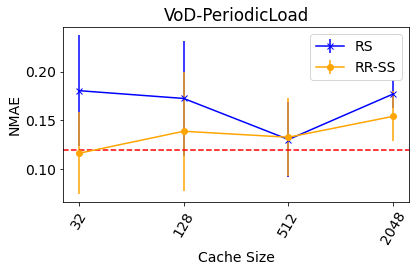

VoD-FlashcrowdLoad - Baseline:
        avg    stddev
0  0.130197  0.000751
VoD-FlashcrowdLoad - RS:
        avg    stddev
0  0.141820  0.033053
1  0.142903  0.029057
2  0.155410  0.011708
3  0.144184  0.010778
VoD-FlashcrowdLoad - RRSS:
        avg    stddev
0  0.131384  0.061150
1  0.143255  0.045766
2  0.144636  0.027150
3  0.145820  0.011931


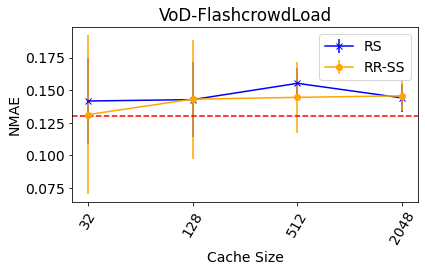

In [7]:
# Project II
# Task II - Online learning on a small-size training set
# VoD - Final Results

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
savedir = "/home/rodolfo/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]

for ds in dsList:

    dfBaseline = pd.read_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv", index_col=None, 
                             usecols = ["avg", "stddev"], header=0)    
    print(ds + " - Baseline:")
    print(dfBaseline)

    dfRS = pd.read_csv(outdir + "p2t2-rs-stats-" + ds + ".csv", index_col=None, 
                            usecols = ["avg", "stddev"], header=0)   
    print(ds + " - RS:")
    print(dfRS)

    dfRRSS = pd.read_csv(outdir + "p2t2-rrss-stats-" + ds + ".csv", index_col=None, 
                         usecols = ["avg", "stddev"], header=0)    
    print(ds + " - RRSS:")
    print(dfRRSS)

    #plt.suptitle("Prediction Error (NMAE)")
    plt.title(ds)
    
    #plt.ylim((0.03, 0.05))
    #plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

    x  = np.array(cacheSizeList)

    yBaseline = np.array(dfBaseline["avg"])
    yRS = np.array(dfRS["avg"])
    yRRSS = np.array(dfRRSS["avg"])

    errorBaseline = np.array(dfBaseline["stddev"])
    errorRS = np.array(dfRS["stddev"])
    errorRRSS = np.array(dfRRSS["stddev"])

    #plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
    #plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

    plt.errorbar(x, yRS, yerr=errorRS, marker='x', label='RS', color = "blue")
    plt.errorbar(x, yRRSS, yerr=errorRRSS, marker='o', label='RR-SS', color = "orange")
    plt.axhline(yBaseline, linestyle ="--", color = "red")

    #plt.plot(x, yRS, marker='x', label='RS', color = "blue")
    #plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

    plt.xlabel("Cache Size")
    plt.xscale('log', basex=2)
    plt.xticks(x, x, rotation=60)

    plt.ylabel("NMAE")
    plt.legend(loc='best')
    #plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
    plt.tight_layout()
    filename = "results/p2t2-" + ds + ".png"
    #print(filename)
    plt.savefig(filename)
    plt.show()
    plt.close()


In [3]:
# Project II
# Task III - Online learning with model re-computation
# VoD - RS

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]
initSize = 1000
trainSize = 100
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)
    #print("Total Size of the Dataset: " + str(dsSize))

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Starting Point: " + str(init))

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(len(cacheX.index))
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            #print("Initial Training Index - 1st Round: " + str(init + cacheSize))

            for index in range(init+cacheSize, init+cacheSize+initSize):
                #print(index-init+1)
                irs = rd.randint(0, index-init)

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                if (irs < cacheSize):
                    #print("Sample#" + str(index) + ": Insert")

                    cacheX = cacheX.drop([irs])
                    cacheY = cacheY.drop([irs])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 1st Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

            init = index + testSize
            
            #print("Final Test Index - 1st Round: " + str(init))

            #print("Initial Training Index - 2nd Round: " + str(init))

            for index in range(init, init+trainSize):
                #print(index-init+1)
                irs = rd.randint(0, index-init)

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                if (irs < cacheSize):
                    #print("Sample#" + str(index) + ": Insert")

                    cacheX = cacheX.drop([irs])
                    cacheY = cacheY.drop([irs])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
             
            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 2nd Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

    print(results)
    results.to_csv(outdir + "p2t3-rs-" + ds + ".csv")


Dataset: VoD-PeriodicLoad
Iteration: 1
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 2
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 3
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 4
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 5
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 6
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 7
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 8
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 9
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 10
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 11
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 12
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 13
Cache Size: 32
Cache Size: 128
Ca

In [4]:
# Project II
# Task III - Online learning with model re-computation
# VoD - RRSS

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]
initSize = 1000
trainSize = 100
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)
    #print("Total Size of the Dataset: " + str(dsSize))

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Starting Point: " + str(init))

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(len(cacheX.index))
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            # Define a sample vector with the average of all columns in the cache
            cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
            #print("cacheAvgSample:")
            #print(cacheAvgSample)

            # Define a vector with the redundancy values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
            #print("cacheRedundancyValues:")
            #print(cacheRedundancyValues)

            # Define a vector with the relevance values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
            #print("cacheRelevanceValues:")eY.drop([irs])
            #print(cacheRelevanceValues)

            # Define a vector with the rank between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
            #print("cacheRankValues:")
            #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

            # Define the mean value of the rank vector
            cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
            #print("cacheRankMean:")
            #print(cacheRankMean[0])

            #print("Initial Training Index - 1st Round: " + str(init + cacheSize))

            for index in range(init+cacheSize, init+cacheSize+initSize):

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)eY.drop([irs])

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
            
                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)

            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 1st Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

            init = index + testSize
            
            #print("Final Test Index - 1st Round: " + str(init))

            #print("Initial Training Index - 2nd Round: " + str(init))

            for index in range(init, init+trainSize):

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)eY.drop([irs])

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
             
                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)

            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 2nd Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

    print(results)
    results.to_csv(outdir + "p2t3-rrss-" + ds + ".csv")


Dataset: VoD-PeriodicLoad
Iteration: 1
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 2
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 3
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 4
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 5
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 6
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 7
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 8
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 9
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 10
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 11
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 12
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 13
Cache Size: 32
Cache Size: 128
Ca

In [5]:
# Project II
# Task III - Online learning with model re-computation
# VoD - Statistics 

# Basic Definitions
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "DispFrames"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t3-rs-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t3-rs-stats-" + ds + ".csv")

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t3-rrss-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t3-rrss-stats-" + ds + ".csv")


Dataset: VoD-PeriodicLoad
     cachesize  iteration      nmae
0         32.0        1.0  0.140650
1         32.0        1.0  0.013030
2        128.0        1.0  0.064912
3        128.0        1.0  0.292525
4        512.0        1.0  0.203219
..         ...        ...       ...
795      128.0      100.0  0.068877
796      512.0      100.0  0.218878
797      512.0      100.0  0.164695
798     2048.0      100.0  0.227161
799     2048.0      100.0  0.187235

[800 rows x 3 columns]
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
   cachesize       avg    stddev
0       32.0  0.137269  0.092455
1      128.0  0.158279  0.071026
2      512.0  0.174242  0.064562
3     2048.0  0.182602  0.045306
Dataset: VoD-FlashcrowdLoad
     cachesize  iteration      nmae
0         32.0        1.0  0.069686
1         32.0        1.0  0.173798
2        128.0        1.0  0.155193
3        128.0        1.0  0.110626
4        512.0        1.0  0.152819
..         ...        ...       ...
795      

VoD-PeriodicLoad - Baseline:
        avg    stddev
0  0.119976  0.000731
VoD-PeriodicLoad - RS:
        avg    stddev
0  0.137269  0.092455
1  0.158279  0.071026
2  0.174242  0.064562
3  0.182602  0.045306
VoD-PeriodicLoad - RRSS:
        avg    stddev
0  0.123338  0.085209
1  0.141285  0.076989
2  0.164929  0.061790
3  0.182959  0.050392


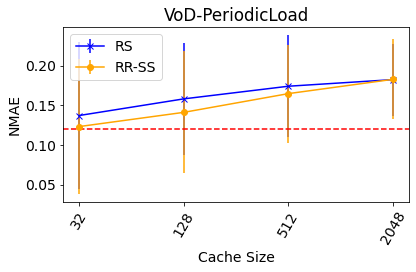

VoD-FlashcrowdLoad - Baseline:
        avg    stddev
0  0.130197  0.000751
VoD-FlashcrowdLoad - RS:
        avg    stddev
0  0.131021  0.058853
1  0.138884  0.041219
2  0.140127  0.030514
3  0.139246  0.030375
VoD-FlashcrowdLoad - RRSS:
        avg    stddev
0  0.133004  0.069229
1  0.139162  0.059004
2  0.134530  0.040517
3  0.141484  0.027698


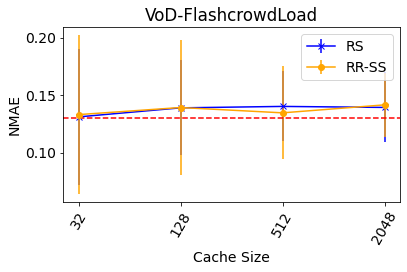

In [2]:
# Project II
# Task III - Online learning with model re-computation
# VoD - Final Results

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
savedir = "/home/rodolfo/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]
dsList = ["VoD-PeriodicLoad", "VoD-FlashcrowdLoad"]

for ds in dsList:

    dfBaseline = pd.read_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv", index_col=None, 
                             usecols = ["avg", "stddev"], header=0)    
    print(ds + " - Baseline:")
    print(dfBaseline)

    dfRS = pd.read_csv(outdir + "p2t3-rs-stats-" + ds + ".csv", index_col=None, 
                            usecols = ["avg", "stddev"], header=0)   
    print(ds + " - RS:")
    print(dfRS)

    dfRRSS = pd.read_csv(outdir + "p2t3-rrss-stats-" + ds + ".csv", index_col=None, 
                         usecols = ["avg", "stddev"], header=0)    
    print(ds + " - RRSS:")
    print(dfRRSS)

    #plt.suptitle("Prediction Error (NMAE)")
    plt.title(ds)
    
    #plt.ylim((0.03, 0.05))
    #plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

    x  = np.array(cacheSizeList)

    yBaseline = np.array(dfBaseline["avg"])
    yRS = np.array(dfRS["avg"])
    yRRSS = np.array(dfRRSS["avg"])

    errorBaseline = np.array(dfBaseline["stddev"])
    errorRS = np.array(dfRS["stddev"])
    errorRRSS = np.array(dfRRSS["stddev"])

    #plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
    #plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

    plt.errorbar(x, yRS, yerr=errorRS, marker='x', label='RS', color = "blue")
    plt.errorbar(x, yRRSS, yerr=errorRRSS, marker='o', label='RR-SS', color = "orange")
    plt.axhline(yBaseline, linestyle ="--", color = "red")

    #plt.plot(x, yRS, marker='x', label='RS', color = "blue")
    #plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

    plt.xlabel("Cache Size")
    plt.xscale('log', basex=2)
    plt.xticks(x, x, rotation=60)

    plt.ylabel("NMAE")
    plt.legend(loc='best')
    #plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
    plt.tight_layout()
    filename = "results/p2t3-" + ds + ".png"
    #print(filename)
    plt.savefig(filename)
    plt.show()
    plt.close()
